# California housing prices dataset

### Uploading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### It's a regression problem. Perfomance Measure - RMSE

$RMSE(X, h) = \sqrt{\frac{1}{m}\Sigma_{i=1}^{m}(h(x)_i - y_i)^2}$

### Quick data description

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67bcc17c90>,
      dtype=object)

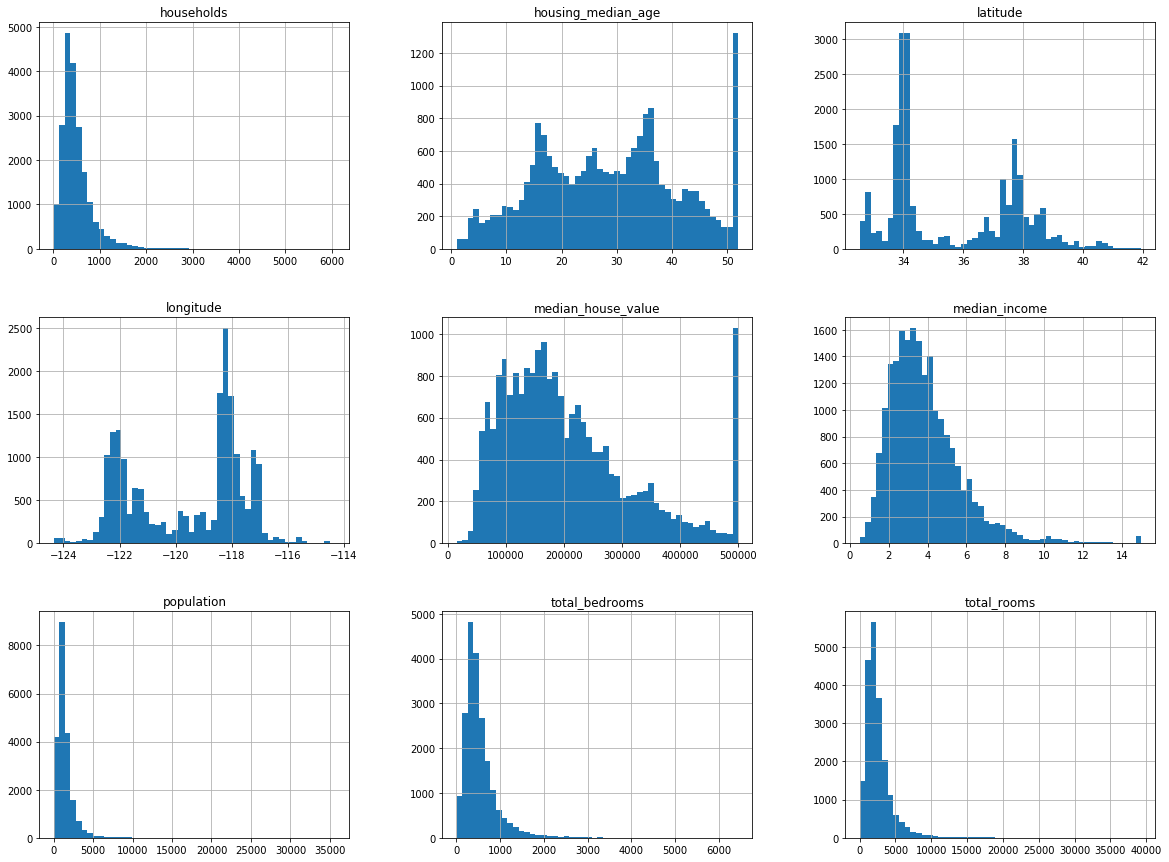

In [6]:
data.hist(bins=50, figsize=(20,15))

Issue 1. Median income and median house value are scaled and capped in range 0.5 - 15 and 14,999 and 500,000 respectively.
ML algorithms may learn the housing prices do not go higher.

Issue 2. These attributes have very different scales.

Issue 3. Many histograms are tail-heavy (right-skewed). It makes difficult for ML to detect patterns. Need to make it more bell-curved.

### Creating a test set

#### Purely random sampling

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

#### Stratified sampling

Let's create a new feature for median income categories

In [8]:
data['income_cat'] = np.ceil(data['median_income'] / 1.5) # 1.5 to limit the number of income categories

In [9]:
data['income_cat'] = np.where(data['income_cat'] < 5, data['income_cat'], 5) # merge all incomes > 5 to category 5

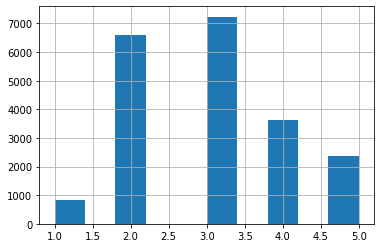

In [10]:
data.income_cat.hist()

Now let's get stratified sampling

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['income_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [12]:
data.income_cat.value_counts() / len(data['income_cat'])

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Stratified sampling gives smaller error than pure random sampling.
Let's remove income_cat from sets.

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

Let's put the testing set aside and explore the training set only.

In [14]:
data = strat_train_set.copy()

## EDA

#### Visualizing Geographical Data

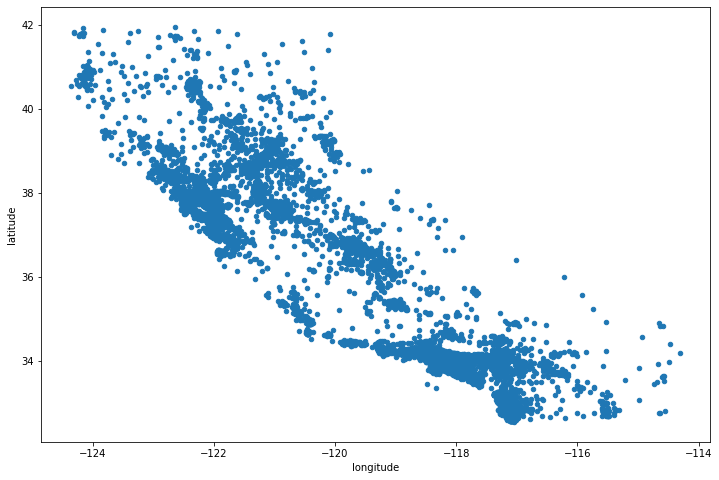

In [15]:
data.plot(kind='scatter', x='longitude', y='latitude', figsize=(12,8))

Looks OK, but let's add alpha parameter to show density

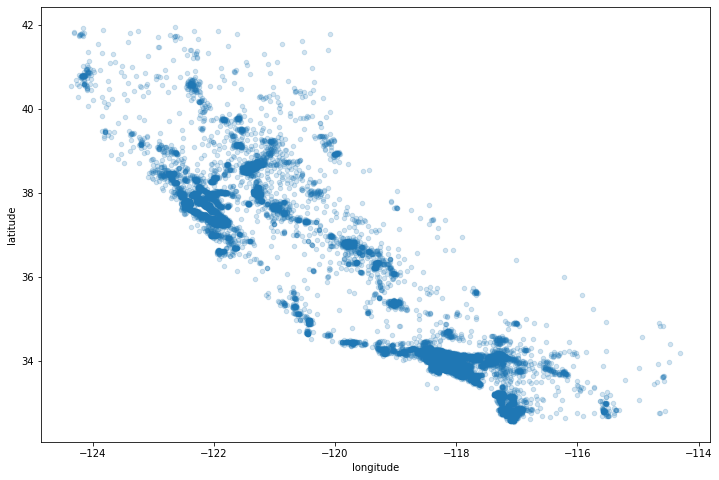

In [16]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, figsize=(12,8))

Much better. Now let's look at the housing prices.

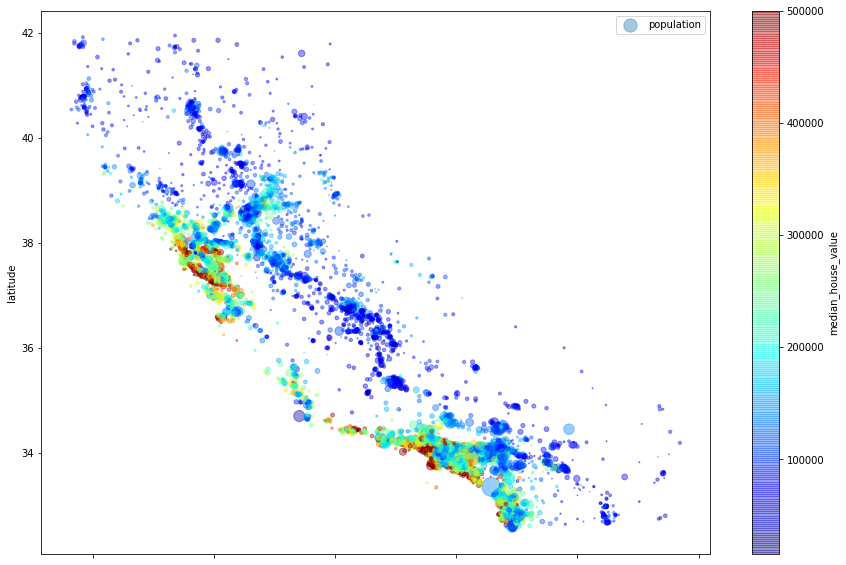

In [17]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
         s=data['population'] / 100, label='population', c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

Insight 1. The housing prices are related to location (ocean proximity) and population density.

Insight 2. A clustering algorithm seems to be useful to add new features (proximity to the clusters).

Insight 3. Ocean proximity does not affect prices in the North, so it's not as simple.

#### Looking for correlations

In [18]:
corr_matrix = data.corr()

In [19]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67b8384550>,
      dtype=object)

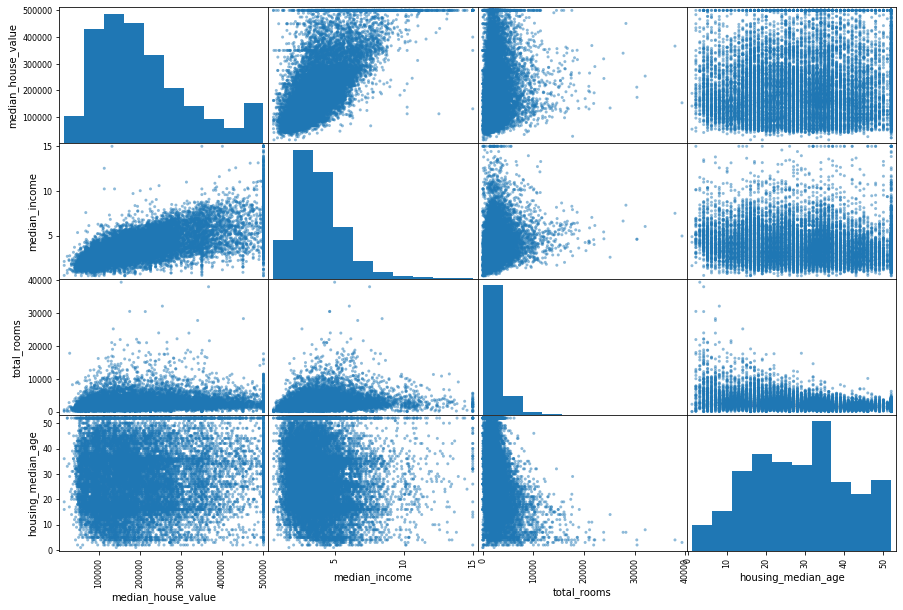

In [20]:
# Visualizing by pandas tools
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(data[attributes], figsize=(15,10))

Let's zoom in the median_income attribute for predicting median_house_value - it's the most promising.

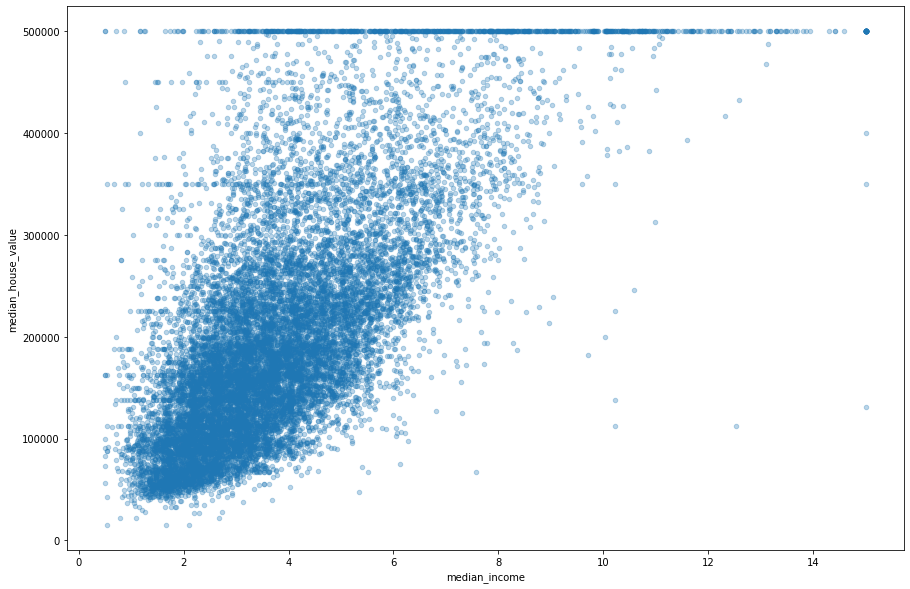

In [21]:
data.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.3, figsize=(15,10))

1. We see strong correlation.

2. We see the 500,000 cap as a straight line. There are also lines at 450,000, 350,000 and some more. We better remove them so not to let algorithms to learn these.

## Experimenting with Attribute Combinations

Let's add some features we are interested in

In [22]:
data['rooms_per_houshold'] = data['total_rooms'] / data['households']
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']

Now let's check the correlations again

In [23]:
corr_matrix = data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_houshold          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

We got bedrooms_per_room much more correlated than total_bedrooms or total_rooms. Rooms_per_houshold is also more correlated.

## Prepare the Data for Machine Learning

Let's separate the predictors and the lables so not to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set )

In [24]:
data = strat_train_set.drop('median_house_value', axis=1)
data_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

3 options to deal with missing values:  
- Get rid of the corresponding districts
- Get rid of the whole attribute
- Set the values to some value (zero, the mean, the median, etc.)

In [25]:
# data.dropna(subset=["total_bedrooms"]) # option 1
# data.drop("total_bedrooms", axis=1) # option 2
median = data["total_bedrooms"].median() # option 3
data["total_bedrooms"].fillna(median, inplace=True)

In [26]:
data["total_bedrooms"].isnull().value_counts()

False    16512
Name: total_bedrooms, dtype: int64

In case option 3, we need to input the median into the test set as well

We can also use the sklearn Imputer instrument as below. We need to eliminate non-number attributes in the dataset for this. The whole dataset is fed to Imputer.

In [27]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
data_num = data.drop('ocean_proximity', axis=1) # making a copy without text attributes
imputer.fit(data_num) # feeding the dataset to Imputer
X = imputer.transform(data_num) # using the trained Imputer to transform data, the result is a NumPy array
data_tr = pd.DataFrame(X, columns=data_num.columns) # putting the array back to a dataframe

/home/artur/anaconda3/envs/hse/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
data.total_bedrooms.isnull().value_counts()

False    16512
Name: total_bedrooms, dtype: int64

### Handling Text and Categorical Attributes

In [29]:
data_cat = data['ocean_proximity']
data_cat_encoded = pd.get_dummies(data_cat)

In [30]:
data.drop('ocean_proximity', axis=1, inplace=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [31]:
data = pd.concat([data, data_cat_encoded], axis=1)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,1,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,1,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,0,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,1,0,0,0,0


### Feature Scaling

We got total_rooms range from about 6 to 39,320 and median_income range from 0 to 15. That's no good, we need to scale that.

2 common ways:  
- Normalization (min-max scaling): values are shifted and rescaled so that they end up ranging from 0 to 1  
- Standartization: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range. However, standardization is much less affected by outliers.

In [32]:
col_names = data_num.columns #save the columns to be scaled, for convenience
col_names

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [33]:
data_scaled = data.copy() # create a copy of the dataframe

In [34]:
from sklearn.preprocessing import StandardScaler

features = data_scaled[col_names]
scaler = StandardScaler().fit(features) 

In [35]:
# don't include categorical features into transformation
features = scaler.transform(features)

In [36]:
# assign the result
data_scaled[col_names] = features
data_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,1,0,0,0,0
18632,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1,0,0,0,0
14650,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,0,0,0,0,1
3230,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,0,1,0,0,0
3555,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,1,0,0,0,0


### Pipeline

Let's make a pipeline so it was easy to prepare the new data next time

In [37]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('imputer', Imputer(strategy='median')), 
                         ('std_scaler', StandardScaler())])

/home/artur/anaconda3/envs/hse/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [38]:
data_tr = num_pipeline.fit_transform(data[col_names])

### Train and Evaluate Linear Regression

We now have data_scaled as 'train X', data_labels as 'train y' and strat_test_set as validation set.

We don't touch the test set until we are sure the model works properly. So we need to evaluate on train set first.

In [39]:
data_train = data_scaled.copy() # rename for convenience

In [40]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_train, data_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
from sklearn.metrics import mean_squared_error

data_predict = lin_reg.predict(data_train)
lin_mse = mean_squared_error(data_labels, data_predict)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.98178244587

Let's try Decision Tree Regressor

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_train, data_labels)
data_predict = tree_reg.predict(data_train)
tree_mse = mean_squared_error(data_labels, data_predict)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It seems to overfit the data. We need cross-validation.

### Cross-validation

In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, data_train, data_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [44]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Std deviation:', scores.std())
display_scores(tree_rmse_scores)

Scores: [66239.85022644 66147.84923852 72589.96432076 69175.99930956
 68331.4850799  75451.90674715 66736.70109622 69807.41291091
 69666.20696764 69433.21293379]
Mean: 69358.05888309039
Std deviation: 2754.449205576873


We see the actual error, so it was overfitting. Let's try the same for linear regression.

In [45]:
lin_scores = cross_val_score(lin_reg, data_train, data_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]
Mean: 69223.18594556303
Std deviation: 2657.2683112776963


Let's try Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(data_train, data_labels)
data_predict = forest_reg.predict(data_train)
forest_mse = mean_squared_error(data_labels, data_predict)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/artur/anaconda3/envs/hse/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


21586.99259369767

In [47]:
forest_scores = cross_val_score(forest_reg, data_train, data_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49963.25246804 48630.1117271  51060.19372256 51932.88410476
 52747.29634523 56609.77700669 51808.74207939 52904.09680627
 53192.96510873 51395.08490598]
Mean: 52024.440427474845
Std deviation: 2020.836684303669


This looks much better, but the model still overfits the training data. So, we need to fine-tune the model.

### GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # 12 combinations of hyperparameters
             {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4,]}] # 6 combinations
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # 5 folds
grid_search.fit(data_train, data_labels) # (12 + 6) * 5 = 90 rounds of training

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [49]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.20552819e-01, 1.09620309e-01, 4.87761421e-02, 2.99466491e-02,
       2.62253209e-02, 3.75800015e-02, 2.57515888e-02, 4.31676901e-01,
       1.93737566e-02, 1.42333361e-01, 6.54152355e-05, 2.27449401e-03,
       5.82324194e-03])

Let’s display these importance scores next to their corresponding attribute names

In [51]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(data_train.loc[:, '<1H OCEAN':'NEAR OCEAN' ].columns)
num_attribs = list(data_train.loc[:, 'longitude':'median_income'].columns)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.43167690081328336, 'median_income'),
 (0.14233336070368963, 'pop_per_hhold'),
 (0.12055281916308462, 'longitude'),
 (0.10962030916164553, 'latitude'),
 (0.04877614207956467, 'housing_median_age'),
 (0.03758000148593854, 'population'),
 (0.02994664911136359, 'total_rooms'),
 (0.02622532086346143, 'total_bedrooms'),
 (0.02575158881305195, 'households'),
 (0.019373756615609163, 'rooms_per_hhold'),
 (0.005823241944896163, 'INLAND'),
 (0.0022744940089050314, '<1H OCEAN'),
 (6.541523550641534e-05, 'bedrooms_per_room')]

### Evaluate on the test set

- Get predictors and labels from the test set
- Transform the data (not fit_transform)
- Evaluate the final model

In [52]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [53]:
X_test['total_bedrooms'].isnull().value_counts() # 49 nulls in test set (we already know nulls are in total_bedrooms only)

False    4079
True       49
Name: total_bedrooms, dtype: int64

In [54]:
X_test_cat = X_test['ocean_proximity']
X_test_cat_encoded = pd.get_dummies(X_test_cat)
X_test.drop('ocean_proximity', axis=1, inplace=True)
X_test = pd.concat([X_test, X_test_cat_encoded], axis=1)
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,1,0,0,0,0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,1,0,0,0,0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,1,0,0,0,0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,0,1,0,0,0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,0,1,0,0,0


In [56]:
median = X_test['total_bedrooms'].median()

In [59]:
X_test_filled = X_test['total_bedrooms'].fillna(median)

In [63]:
X_test['total_bedrooms'] = X_test_filled
X_test['total_bedrooms'].isnull().value_counts()

False    4128
Name: total_bedrooms, dtype: int64

In [67]:
sc = StandardScaler().fit(data[col_names])
X_test_toscale = X_test[col_names]
X_test_scaled = sc.transform(X_test_toscale)
X_test[col_names] = X_test_scaled
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,0.592384,-0.710749,0.027588,1.788385,1.163511,0.684989,1.232174,2.312998,1,0,0,0,0
10970,0.857146,-0.874454,0.822858,0.718423,0.294532,0.223375,0.409730,0.386117,1,0,0,0,0
20351,0.262681,-0.668654,-0.131466,0.811016,0.954177,0.618660,1.008597,-0.453406,1,0,0,0,0
6568,0.712276,-0.673331,1.856709,-0.391288,-0.554973,-0.360140,-0.465946,0.145001,0,1,0,0,0
13285,0.947065,-0.734136,0.266169,-0.396432,-0.535500,-0.316219,-0.519179,0.084997,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20519,-0.976205,1.375319,0.345696,1.106097,1.545667,0.891146,1.538262,-0.998896,0,1,0,0,0
17430,-0.431695,-0.462853,0.107115,-0.167288,-0.053546,-0.015947,-0.069363,-0.997741,0,0,0,0,1
4019,0.542429,-0.682686,0.186642,0.210565,0.340780,0.059346,0.497564,0.536939,1,0,0,0,0
12107,1.126903,-0.771554,-0.131466,1.328694,0.769184,0.878597,0.902132,0.438561,0,1,0,0,0


In [68]:
final_predict = final_model.predict(X_test)

In [69]:
final_mse = mean_squared_error(y_test, final_predict)
final_rmse = np.sqrt(final_mse)

In [70]:
final_rmse

47256.39605567675